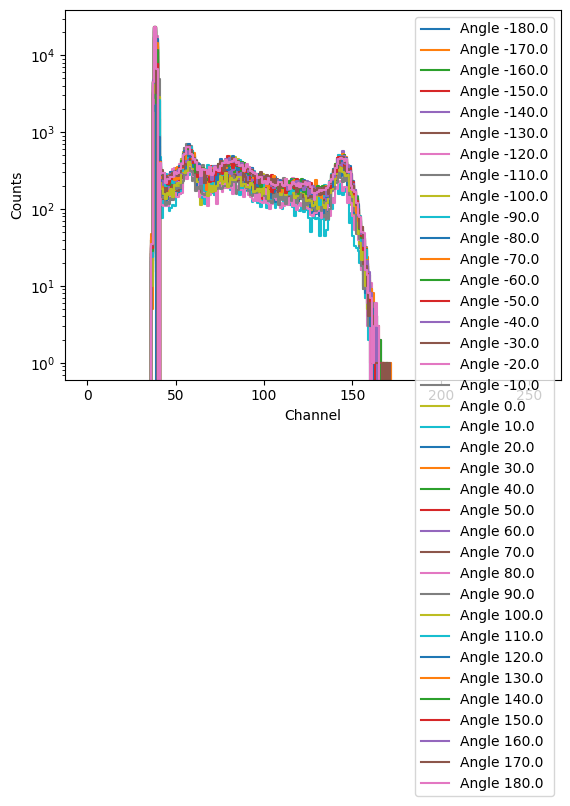

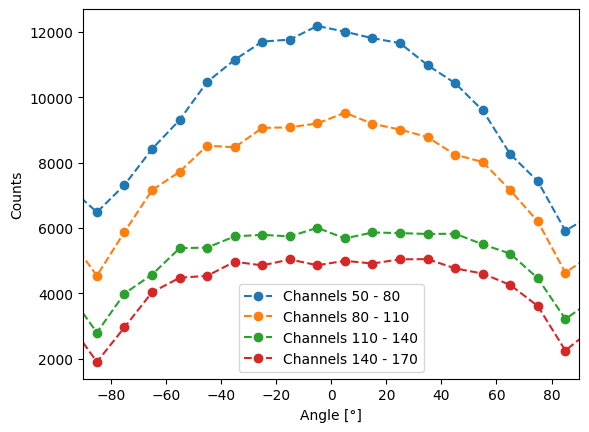

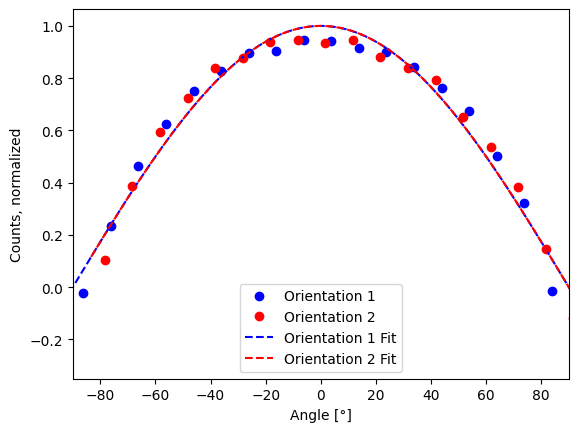

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
# %matplotlib widget

df = pd.read_csv('../data/rotcal/rotcal_cs.csv')
df_background = pd.read_csv('../data/rotcal/rotcal_cs_bkg.csv')
df_bok = pd.read_csv('../data/rotcal/rotcal_cs_bok.csv')
df_bok_bkg = pd.read_csv('../data/rotcal/rotcal_cs_bok_bkg.csv')
angles = df.values[:, 0]
angles_bok = df_bok.values[:, 0]
exposures = df.values[:, 4:]
exposures_bkg = df_background.values[:, 4:]
exposures_bok = df_bok.values[:, 4:]
exposures_bok_bkg = df_bok_bkg.values[:, 4:]

channels = np.arange(256)

exposures = exposures - exposures_bkg
exposures_bok = exposures_bok - exposures_bok_bkg

plt.figure()
for i in range(exposures.shape[0]):
    plt.step(channels, exposures[i, :], label=f"Angle {angles[i]}")
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.show()

    

partial_counts_p0 = [np.sum(exposures[:, ch:ch+30], axis=1) for ch in range(50, 150, 30)]
plt.figure()
plt.xlim(-90, 90)
for i, counts in enumerate(partial_counts_p0):
    plt.plot(angles+5, counts, '--o', label=f"Channels {50 + i*30} - {80 + i*30}")
plt.xlabel('Angle [°]')
plt.ylabel('Counts')
plt.legend()
plt.savefig('../outputs/rot-calib/rot_channel_bands.pdf')
plt.show()
# ch0_filter = chs == 0

def peak_func(angle, center, A, bkg):
    return A * np.cos(np.deg2rad(angle - center)) + bkg

angles_filter = (angles > -95) & (angles < 85)
angles_bok_filter = (angles_bok > -95) & (angles_bok < 85)
angles = angles[angles_filter]
angles_bok = angles_bok[angles_bok_filter]
total_counts_p0 = np.sum(exposures[angles_filter, 50:150], axis=1)
total_counts_p1 = np.sum(exposures_bok[angles_bok_filter, 50:150], axis=1)

peak_func_fit_p0, peak_func_fit_p0_cov = curve_fit(peak_func, angles, total_counts_p0, p0=[0, 30000, 10000])
peak_func_fit_p1, peak_func_fit_p1_cov = curve_fit(peak_func, angles_bok, total_counts_p1, p0=[0, 20000, 10000])

model_angles = np.linspace(-95, 95, 1000)
model_counts_p0 = peak_func(model_angles, *peak_func_fit_p0)
model_counts_p1 = peak_func(model_angles, *peak_func_fit_p1)

p0_A = peak_func_fit_p0[1]
p1_A = peak_func_fit_p1[1]
p0_bkg = peak_func_fit_p0[2]
p1_bkg = peak_func_fit_p1[2]
p0_center = peak_func_fit_p0[0]
p1_center = peak_func_fit_p1[0]

plt.figure()
plt.plot(angles - p0_center, (total_counts_p0 - p0_bkg) / p0_A, 'o', color='blue', label="Orientation 1")
plt.plot(angles_bok - p1_center, (total_counts_p1 - p1_bkg) / p1_A, 'o', color='red', label="Orientation 2")
plt.plot(model_angles - p0_center, (model_counts_p0 - p0_bkg) / p0_A, '--', color='blue', label="Orientation 1 Fit")
plt.plot(model_angles - p1_center, (model_counts_p1 - p1_bkg) / p1_A, '--', color='red', label="Orientation 2 Fit")
plt.xlim(-90, 90)
plt.legend()
plt.xlabel('Angle [°]')
plt.ylabel('Counts, normalized')
plt.savefig('../outputs/rot-calib/rot_all_channels.pdf')
plt.show()

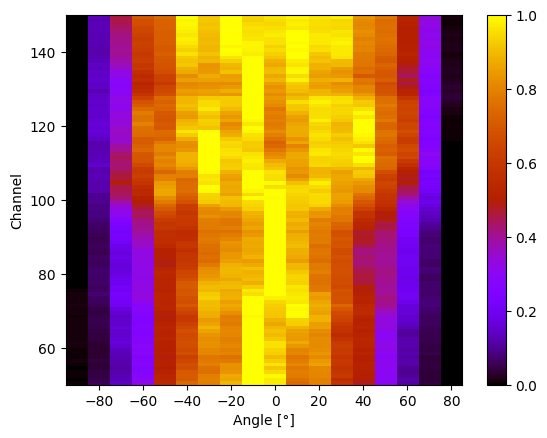

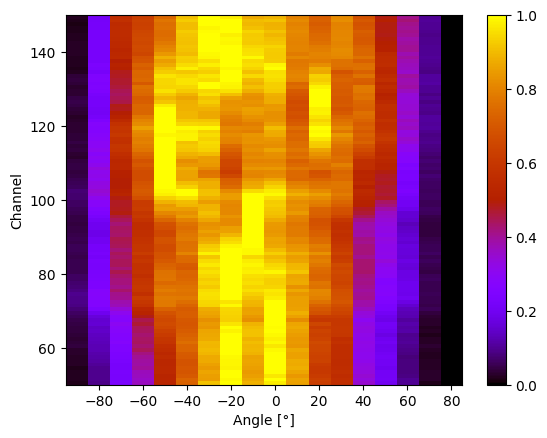

In [3]:
conv_len = 20
conv_filter = np.ones(conv_len) / conv_len
p0_sums = []
p1_sums = []
for i in range(exposures.shape[0]):
    p0_sums.append(np.convolve(exposures[i, 50:150], conv_filter, mode='same'))
for i in range(exposures_bok.shape[0]):
    p1_sums.append(np.convolve(exposures_bok[i, 50:150], conv_filter, mode='same'))

p0_sums = np.array(p0_sums)[angles_filter] 
p1_sums = np.array(p1_sums)[angles_bok_filter]

p0_sums = (p0_sums - np.min(p0_sums, axis=0))
p0_sums = p0_sums / np.max(p0_sums, axis=0)

p1_sums = (p1_sums - np.min(p1_sums, axis=0))
p1_sums = p1_sums / np.max(p1_sums, axis=0)

# Draw 2D image
plt.figure()
plt.imshow(p0_sums.T[::-1,:]**2, aspect='auto', extent=[-95, 85, 50, 150], cmap='gnuplot')
plt.colorbar()
plt.xlabel('Angle [°]')
plt.ylabel('Channel')
plt.savefig('../outputs/rot-calib/rot_spectrogram_p0.pdf')
plt.show()

plt.figure()
plt.imshow(p1_sums.T[::-1,:]**2, aspect='auto', extent=[-95, 85, 50, 150], cmap='gnuplot')
plt.colorbar()
plt.xlabel('Angle [°]')
plt.ylabel('Channel')
plt.savefig('../outputs/rot-calib/rot_spectrogram_p1.pdf')
plt.show()